In [1]:
# importamos todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification


### 1. Carga y Exploración Inicial de Datos:
* Cargar el dataset desde Kaggle.
* Realizar una exploración inicial para entender la estructura del dataset y las características disponibles.
* Identificar y documentar los valores faltantes y outliers en el dataset.

In [2]:
# cargamos el dataset desde el archivo csv
ruta='../data/insurance.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(1338, 7)

In [3]:
df.info() # vermos informacion sobre el dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isnull().sum() # verificamos si exiten valores nulos

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

* Diccionario de datos del dataset
    * age: Edad del individuo.
    * sex: Sexo del individuo (femenino o masculino).
    * bmi: Índice de masa corporal (relación peso/altura).
    * children: Número de hijos dependientes.
    * smoker: Indica si el individuo es fumador (sí/no).
    * region: Región geográfica en la que reside el individuo.
    * charges: Costo del seguro de salud.

In [5]:
df.head() # listamos las primeras 5 filas

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.describe() # estadistica descriptiva del dataset

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### 2. Preprocesamiento de Datos:
* Imputar valores faltantes utilizando técnicas adecuadas (media, mediana, moda, imputación avanzada).
* Codificar variables categóricas utilizando One-Hot Encoding.
* Escalar características numéricas utilizando StandardScaler.

In [7]:
# Aplicamos One-Hot Encoding para las columnas sex, smoker y region
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=False)
print(df_encoded) # mostramos el df resultante de df_encoded

      age     bmi  children      charges  sex_female  sex_male  smoker_no  \
0      19  27.900         0  16884.92400        True     False      False   
1      18  33.770         1   1725.55230       False      True       True   
2      28  33.000         3   4449.46200       False      True       True   
3      33  22.705         0  21984.47061       False      True       True   
4      32  28.880         0   3866.85520       False      True       True   
...   ...     ...       ...          ...         ...       ...        ...   
1333   50  30.970         3  10600.54830       False      True       True   
1334   18  31.920         0   2205.98080        True     False       True   
1335   18  36.850         0   1629.83350        True     False       True   
1336   21  25.800         0   2007.94500        True     False       True   
1337   61  29.070         0  29141.36030        True     False      False   

      smoker_yes  region_northeast  region_northwest  region_southeast  \
0

In [8]:
# seleccionamos solo las columnas numéricas para escalar
num_columns = ['age', 'bmi', 'children', 'charges']
# creamos el objeto StandardScaler
scaler = StandardScaler()
# ajustamos y transformamos las columnas numéricas
df[num_columns] = scaler.fit_transform(df[num_columns])
# mostrar el DataFrame escalado
print(df)

           age     sex       bmi  children smoker     region   charges
0    -1.438764  female -0.453320 -0.908614    yes  southwest  0.298584
1    -1.509965    male  0.509621 -0.078767     no  southeast -0.953689
2    -0.797954    male  0.383307  1.580926     no  southeast -0.728675
3    -0.441948    male -1.305531 -0.908614     no  northwest  0.719843
4    -0.513149    male -0.292556 -0.908614     no  northwest -0.776802
...        ...     ...       ...       ...    ...        ...       ...
1333  0.768473    male  0.050297  1.580926     no  northwest -0.220551
1334 -1.509965  female  0.206139 -0.908614     no  northeast -0.914002
1335 -1.509965  female  1.014878 -0.908614     no  southeast -0.961596
1336 -1.296362  female -0.797813 -0.908614     no  southwest -0.930362
1337  1.551686  female -0.261388 -0.908614    yes  northwest  1.311053

[1338 rows x 7 columns]


### 3. Implementación de Modelos de Clasificación:
* Entrenar y evaluar al menos tres modelos de clasificación diferentes: Regresión Logística, K-Nearest Neighbors (KNN), y Árbol de Decisión.
* Utilizar validación cruzada para evaluar el rendimiento inicial de los modelos.

In [9]:
# creamos una columna binaria 'high_charges' (1 si charges > mediana, sino 0)
median_charges = df['charges'].median()
df['high_charges'] = (df['charges'] > median_charges).astype(int)
# seleccionamos las características y la variable objetivo
X = df[['age', 'bmi', 'children', 'sex', 'smoker', 'region']]
y = df['high_charges']
# realizamos One-Hot Encoding para las variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)
# escalamos las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
# dividimos el dataset en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# creamos y entrenamos los modelos
# Regresión Logística
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
# Árbol de Decisión
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [10]:
# realizamos predicciones en el conjunto de prueba
y_pred_log_reg = log_reg.predict(X_test) # regresion logistica
y_pred_knn = knn.predict(X_test) # knn
y_pred_tree = tree.predict(X_test) # arbol de eecisiones

# evaluamos los modelos
print("Evaluación de Regresión Logística:")
print(f"Precisión: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Matriz de Confusión:\n{confusion_matrix(y_test, y_pred_log_reg)}")
print(f"Reporte de Clasificación:\n{classification_report(y_test, y_pred_log_reg)}")

print("\nEvaluación de K-Nearest Neighbors (KNN):")
print(f"Precisión: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Matriz de Confusión:\n{confusion_matrix(y_test, y_pred_knn)}")
print(f"Reporte de Clasificación:\n{classification_report(y_test, y_pred_knn)}")

print("\nEvaluación de Árbol de Decisión:")
print(f"Precisión: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Matriz de Confusión:\n{confusion_matrix(y_test, y_pred_tree)}")
print(f"Reporte de Clasificación:\n{classification_report(y_test, y_pred_tree)}")

Evaluación de Regresión Logística:
Precisión: 0.9030
Matriz de Confusión:
[[187  20]
 [ 19 176]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       207
           1       0.90      0.90      0.90       195

    accuracy                           0.90       402
   macro avg       0.90      0.90      0.90       402
weighted avg       0.90      0.90      0.90       402


Evaluación de K-Nearest Neighbors (KNN):
Precisión: 0.8756
Matriz de Confusión:
[[181  26]
 [ 24 171]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       207
           1       0.87      0.88      0.87       195

    accuracy                           0.88       402
   macro avg       0.88      0.88      0.88       402
weighted avg       0.88      0.88      0.88       402


Evaluación de Árbol de Decisión:
Precisión: 0.8706
Matriz de Confusión:
[[176  31]
 [ 21 174

In [12]:
# modelos a evaluar
models = {
    "Regresión Logística": LogisticRegression(),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=3),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42)
}

# Evaluación con validación cruzada
for model_name, model in models.items():
    print("-" * 50) # separamos con una lina de - (para que sea mas ordenado)
    print(f"Evaluación de {model_name}:")
    print("-" * 50) # separamos con una lina de -
    # Realizar validación cruzada (usamos 5 folds)
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')  # 'accuracy' es la métrica de evaluación
    print(f"Precisión promedio: {np.mean(scores):.4f}")
    print(f"Desviación estándar de las puntuaciones: {np.std(scores):.4f}")
    print(f"Puntuaciones individuales: {scores}\n") # agegamos al final el salto de linea para separar por modelos

--------------------------------------------------
Evaluación de Regresión Logística:
--------------------------------------------------
Precisión promedio: 0.9096
Desviación estándar de las puntuaciones: 0.0279
Puntuaciones individuales: [0.95895522 0.87313433 0.91044776 0.90636704 0.8988764 ]

--------------------------------------------------
Evaluación de K-Nearest Neighbors (KNN):
--------------------------------------------------
Precisión promedio: 0.8923
Desviación estándar de las puntuaciones: 0.0221
Puntuaciones individuales: [0.92910448 0.8880597  0.89925373 0.88389513 0.86142322]

--------------------------------------------------
Evaluación de Árbol de Decisión:
--------------------------------------------------
Precisión promedio: 0.8849
Desviación estándar de las puntuaciones: 0.0228
Puntuaciones individuales: [0.91791045 0.84701493 0.88059701 0.89138577 0.88764045]



### 4. Optimización de Hiperparámetros:
* Implementar GridSearchCV para optimizar los hiperparámetros de los modelos seleccionados.
* Implementar RandomizedSearchCV como método alternativo de optimización.
* Comparar los resultados de GridSearchCV y RandomizedSearchCV para los modelos optimizados.

In [16]:
# 1. Regresión Logística
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularización
    'solver': ['liblinear', 'saga']  # Solvers disponibles
}

# 2. K-Nearest Neighbors (KNN)
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Método de ponderación
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algoritmos de búsqueda de vecinos
}

# 3. Árbol de Decisión
tree_param_grid = {
    'max_depth': [3, 5, 10, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'criterion': ['gini', 'entropy']  # Criterio de división
}

# Modelos a optimizar con GridSearchCV
models = {
    "Regresión Logística": LogisticRegression(),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42)
}

# Diccionario para guardar los resultados de GridSearchCV
grid_search_results = {}

# Ejecutar GridSearchCV para cada modelo
for model_name, model in models.items():
    if model_name == "Regresión Logística":
        param_grid = log_reg_param_grid
    elif model_name == "K-Nearest Neighbors (KNN)":
        param_grid = knn_param_grid
    else:
        param_grid = tree_param_grid
    
    # Crear GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Ejecutar GridSearchCV
    grid_search.fit(X_scaled, y)
    
    # Guardar los resultados
    grid_search_results[model_name] = {
        'Best Score': grid_search.best_score_,
        'Best Params': grid_search.best_params_,
        'All Results': grid_search.cv_results_
    }

# Mostrar los resultados de GridSearchCV para cada modelo
for model_name, result in grid_search_results.items():
    print("-" * 60)
    print(f"Resultados de GridSearchCV para {model_name}:")
    print("-" * 60)
    print(f"Mejor Precisión: {result['Best Score']:.4f}")
    print(f"Mejores Parámetros: {result['Best Params']}\n")
    


/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

------------------------------------------------------------
Resultados de GridSearchCV para Regresión Logística:
------------------------------------------------------------
Mejor Precisión: 0.9118
Mejores Parámetros: {'C': 10, 'solver': 'liblinear'}

------------------------------------------------------------
Resultados de GridSearchCV para K-Nearest Neighbors (KNN):
------------------------------------------------------------
Mejor Precisión: 0.9073
Mejores Parámetros: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}

------------------------------------------------------------
Resultados de GridSearchCV para Árbol de Decisión:
------------------------------------------------------------
Mejor Precisión: 0.9223
Mejores Parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}



In [18]:

# Definir los rangos de hiperparámetros para cada modelo
# Regresión Logística
log_reg_param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularización (en una escala logarítmica)
    'solver': ['liblinear', 'saga']  # Solvers disponibles
}

# K-Nearest Neighbors (KNN)
knn_param_dist = {
    'n_neighbors': np.arange(1, 21),  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Método de ponderación
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algoritmos de búsqueda de vecinos
}

# Árbol de Decisión
tree_param_dist = {
    'max_depth': [3, 5, 10, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'criterion': ['gini', 'entropy']  # Criterio de división
}

# modelos a optimizar con RandomizedSearchCV
models = {
    "Regresión Logística": LogisticRegression(),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42)
}

# creamos un diccionario para guardar los resultados de RandomizedSearchCV
random_search_results = {}

# ejecutamos RandomizedSearchCV para cada modelo
# con nombre del modelo como clave y el objeto del modelo como valor
for model_name, model in models.items():
    # si el modelo es Regresión Logística, asigna su distribución de hiperparámetros
    if model_name == "Regresión Logística":
        param_dist = log_reg_param_dist
    # si el modelo es K-Nearest Neighbors (KNN), asigna su distribución de hiperparámetros
    elif model_name == "K-Nearest Neighbors (KNN)":
        param_dist = knn_param_dist
    # si el modelo no es ni Regresión Logística ni KNN, asigna la distribución de hiperparámetros de Árbol de Decisión
    else:
        param_dist = tree_param_dist
    
    # creamos el objeto RandomizedSearchCV con los parámetros específicos para el modelo actual
    random_search = RandomizedSearchCV(
        estimator=model,  # modelo a ajustar
        param_distributions=param_dist,  # distribución de hiperparámetros
        n_iter=10, # número de combinaciones aleatorias a probar
        cv=5, # número de particiones en la validación cruzada
        scoring='accuracy', # métrica para evaluar el modelo
        n_jobs=-1,  # Usamos todos los núcleos del procesador disponibles para acelerar la búsqueda
        random_state=42 # establecer semilla para reproducibilidad
    )
    
    # ejecutamos la búsqueda aleatoria de hiperparámetros en los datos de entrenamiento escalados
    random_search.fit(X_scaled, y)
    # guardar los resultados de la búsqueda en un diccionario para el modelo actual
    random_search_results[model_name] = {
        'Best Score': random_search.best_score_, # mejor puntuación (exactitud) obtenida
        'Best Params': random_search.best_params_, # mejores hiperparámetros encontrados
        'All Results': random_search.cv_results_ # resultados de la validación cruzada para análisis posterior
    }

# mostramos los resultados de RandomizedSearchCV para cada modelo
for model_name, result in random_search_results.items():
    print("-" * 60) # mostramos una línea separadora para mejorar la legibilidad
    print(f"Resultados de RandomizedSearchCV para {model_name}:")  # mostramos el nombre del modelo en los resultados
    print("-" * 60) # mostramos otra línea separadora para mejorar la legibilidad
    print(f"Mejor Precisión: {result['Best Score']:.4f}")  # mostramos la mejor precisión obtenida por el modelo con 4 decimales
    print(f"Mejores Parámetros: {result['Best Params']}\n") # mostramos los mejores hiperparámetros encontrados por la búsqueda aleatoria
    

/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

------------------------------------------------------------
Resultados de RandomizedSearchCV para Regresión Logística:
------------------------------------------------------------
Mejor Precisión: 0.9118
Mejores Parámetros: {'solver': 'saga', 'C': 10.0}

------------------------------------------------------------
Resultados de RandomizedSearchCV para K-Nearest Neighbors (KNN):
------------------------------------------------------------
Mejor Precisión: 0.9095
Mejores Parámetros: {'weights': 'distance', 'n_neighbors': 8, 'algorithm': 'ball_tree'}

------------------------------------------------------------
Resultados de RandomizedSearchCV para Árbol de Decisión:
------------------------------------------------------------
Mejor Precisión: 0.9223
Mejores Parámetros: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'gini'}



In [27]:
# comparamos los resultados de GridSearchCV y RandomizedSearchCV
for model_name in models.keys():
    print("-" * 70) # mostramos una línea separadora para mejorar la legibilidad
    print(f"Comparación de resultados para {model_name}:") # mostramos el título de la comparación para el modelo actual
    print("-" * 70) # mostramos otra línea separadora para mejorar la legibilidad
    # resultados de GridSearchCV
    grid_best_score = grid_search_results[model_name]['Best Score']  # mejor puntuación de GridSearchCV
    grid_best_params = grid_search_results[model_name]['Best Params']  # mejores hiperparámetros de GridSearchCV
    # resultados de RandomizedSearchCV
    random_best_score = random_search_results[model_name]['Best Score']  # mejor puntuación de RandomizedSearchCV
    random_best_params = random_search_results[model_name]['Best Params']  # mejores hiperparámetros de RandomizedSearchCV
    
    # mostramos las comparaciones de la precision
    print(f"  Mejor Precisión con GridSearchCV: {grid_best_score:.4f}")  # precision con GridSearchCV
    print(f"  Mejor Precisión con RandomizedSearchCV: {random_best_score:.4f}")  # precision con RandomizedSearchCV
    # mostramos los mejores hiperparámetros obtenidos por cada busqueda
    print(f"  Mejores Parámetros con GridSearchCV: {grid_best_params}")  # hiperparametros de GridSearchCV
    print(f"  Mejores Parámetros con RandomizedSearchCV: {random_best_params}")  # hiperparametros de RandomizedSearchCV

    # comparamos el numero de combinaciones probadas en cada busqueda
    grid_combinations = len(grid_search_results[model_name]['All Results']['params'])  # numero de combinaciones de GridSearchCV
    random_combinations = len(random_search_results[model_name]['All Results']['params'])  # numero de combinaciones de RandomizedSearchCV
    # mostramos la comparación del numero de combinaciones probadas
    print(f"  Número de combinaciones probadas con GridSearchCV: {grid_combinations}")  # combinaciones de GridSearchCV
    print(f"  Número de combinaciones probadas con RandomizedSearchCV: {random_combinations}\n")  # combinaciones de RandomizedSearchCV


----------------------------------------------------------------------
Comparación de resultados para Regresión Logística:
----------------------------------------------------------------------
  Mejor Precisión con GridSearchCV: 0.9118
  Mejor Precisión con RandomizedSearchCV: 0.9118
  Mejores Parámetros con GridSearchCV: {'C': 10, 'solver': 'liblinear'}
  Mejores Parámetros con RandomizedSearchCV: {'solver': 'saga', 'C': 10.0}
  Número de combinaciones probadas con GridSearchCV: 10
  Número de combinaciones probadas con RandomizedSearchCV: 10

----------------------------------------------------------------------
Comparación de resultados para K-Nearest Neighbors (KNN):
----------------------------------------------------------------------
  Mejor Precisión con GridSearchCV: 0.9073
  Mejor Precisión con RandomizedSearchCV: 0.9095
  Mejores Parámetros con GridSearchCV: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
  Mejores Parámetros con RandomizedSearchCV: {'weights

### 5. Evaluación de Modelos:
* Evaluar los modelos optimizados utilizando métricas de rendimiento como exactitud, precisión, recall, F1-Score y ROC-AUC.
* Generar y analizar la matriz de confusión para los modelos optimizados.
* Crear y visualizar la curva ROC para evaluar la capacidad del modelo para distinguir entre clases.

In [21]:
# crear un dataset sintético
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo
model = RandomForestClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades para el AUC


In [22]:
# Exactitud
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy:.4f}')

# Precisión
precision = precision_score(y_test, y_pred)
print(f'Precisión: {precision:.4f}')

# Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC: {roc_auc:.4f}')


Exactitud: 0.9000
Precisión: 0.9485
Recall: 0.8598
F1-Score: 0.9020
ROC-AUC: 0.9379


* el 90% de las predicciones fueron correctas
* tiene una precision del 94.85%
* el recall màs bajo que la preciciòn puede indicar que hay falsos negativos
* F1-Score indica que el modelo es bueno
* el ROC-AUC cerca de 1 indica que el rendimiento global es bueno

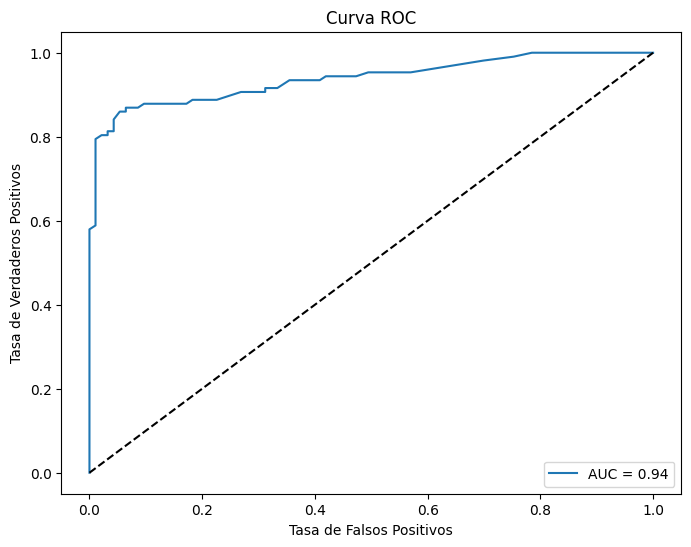

In [23]:
# Calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (modelo aleatorio)
plt.xlabel('Tasa de Falsos Positivos') # titulo del eje x
plt.ylabel('Tasa de Verdaderos Positivos') # titulo del eje y
plt.title('Curva ROC') # titulo del grafico
plt.legend(loc='lower right') # agregamos la leyenda
plt.show() # mostramos el grafico


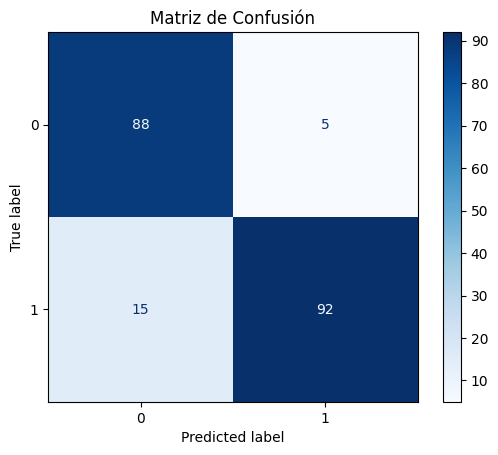

Matriz de Confusión:
[[88  5]
 [15 92]]


In [30]:
# generamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')  # color para el mapa de calor
plt.title('Matriz de Confusión') # titulo del grafico
plt.show() # mostramos el grafico

# mostramos la matriz de confusión
print("Matriz de Confusión:")
print(cm)


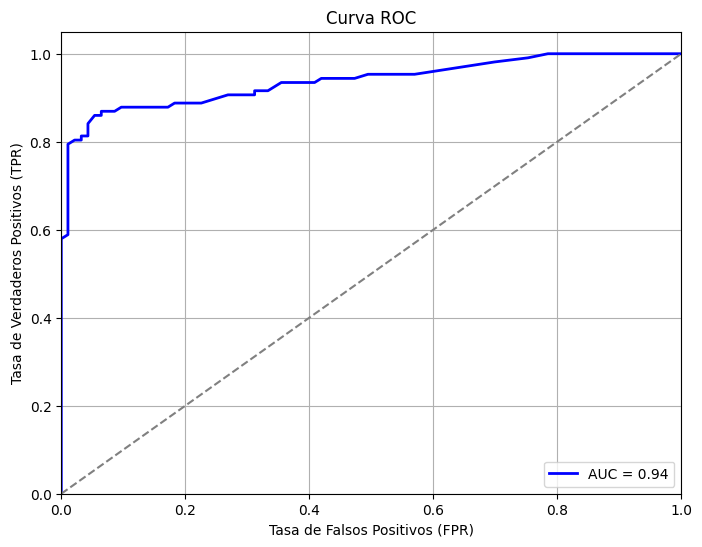

In [34]:
# calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# calculamo el AUC 
roc_auc = auc(fpr, tpr)

# graficamos la Curva ROC
plt.figure(figsize=(8, 6)) # dimensiones de la grafica
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}') # parametros
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # línea diagonal
plt.xlim([0.0, 1.0]) # distribucion entre 0 y 1
plt.ylim([0.0, 1.05]) # distribucion entre 0 y 1.05
plt.xlabel('Tasa de Falsos Positivos (FPR)') # titulo del eje x
plt.ylabel('Tasa de Verdaderos Positivos (TPR)') # titulo del eje y
plt.title('Curva ROC') # Titulo del grafico
plt.legend(loc='lower right') # leyenda del grafico, posicion inferior derecha
plt.grid(True) # mostramos cuadriculas
plt.show() # mostramos el grafico
